In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = '/content'

In [ ]:
!kaggle datasets download -d gaurav41/voxceleb1-audio-wav-files-for-india-celebrity

100% 932M/933M [00:37<00:00, 29.6MB/s]
100% 933M/933M [00:37<00:00, 25.9MB/s]


In [ ]:
%cd /content/drive/MyDrive/Datasets/vox_indian_spectograms

[Errno 2] No such file or directory: '/content/drive/MyDrive/Datasets/vox_indian_spectograms'
/content


In [ ]:
!unzip /content/drive/MyDrive/Datasets/vox_indian_spectograms/spectrograms-20230206T175643Z-001.zip

Archive:  /content/drive/MyDrive/Datasets/vox_indian_spectograms/spectrograms-20230206T175643Z-001.zip
  inflating: spectrograms/id10943/y5JWex5vBkQ/00003.npy  
  inflating: spectrograms/id10943/y5JWex5vBkQ/00002.npy  
  inflating: spectrograms/id10943/y5JWex5vBkQ/00001.npy  
  inflating: spectrograms/id10943/y5JWex5vBkQ/00004.npy  
  inflating: spectrograms/id10943/khscBlibcsE/00001.npy  
  inflating: spectrograms/id10943/khscBlibcsE/00002.npy  
  inflating: spectrograms/id10943/AbPqanBryDQ/00003.npy  
  inflating: spectrograms/id10943/AbPqanBryDQ/00002.npy  
  inflating: spectrograms/id10943/AbPqanBryDQ/00001.npy  
  inflating: spectrograms/id10943/Ww-kQ21VPmU/00001.npy  
  inflating: spectrograms/id10943/vNCVj7yLWPU/00001.npy  
  inflating: spectrograms/id10943/vNCVj7yLWPU/00005.npy  
  inflating: spectrograms/id10943/vNCVj7yLWPU/00004.npy  
  inflating: spectrograms/id10943/vNCVj7yLWPU/00003.npy  
  inflating: spectrograms/id10943/cXoCSD3k-8g/00001.npy  
  inflating: spectrograms/i

In [ ]:
import os

import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.utils.data
import torch.nn.functional as F

from librosa.filters import mel as librosa_mel_fn
from librosa.util import normalize
from scipy.io.wavfile import read

ALLOWED_EXTS = [x.upper() for x in ['.wav', '.m4a', '.flac']]
top_DB_dict = {'VCTK': 15, 'VC1': 23, 'VC1T': 23, 'VC2': 23, 'Libri': 23}
MAX_WAV_VALUE = 32768.0

In [ ]:
hp = {
    "audio": {
        "raw_vox": "/content/drive/MyDrive/V_Auth_dataset/vox1_indian/content/vox_indian",
        "meta_file": "/content/drive/MyDrive/V_Auth_dataset/vox1_meta.csv"
    },
    
    
    "Sound": {
        "N_FFT": 1024,
        "Mel_Dim": 80,
        "Frame_Length": 1024,
        "Frame_Shift": 256,
        "Sample_Rate": 22050,
        "Mel_F_Min": 0,
        "Mel_F_Max": 8000,
    },

    "GE2E":{
        "Embedding_Size": 256,
        "Positional_Encoding": {
            "Max_Position": 1024,
            "Dropout_Rate": 0.1,
            },
        
        "Transformer":{
            "Num_Layers": 3,
            "Head": 4,
            "Dropout_Rate": 0.1,
            }
    },
    
    "Training": {
        "Use_Pattern_Cache": False,
        "Train_Pattern": {
            "Path": "./train/",
            "Metadata_File": "train_metadata.pickle",
        },
        "Eval_Pattern": {
            "Path": './eval/',
            "Metadata_File": 'eval_metadata.pickle',
        },

        # Each epoch is based on the number of speakers, so using a lot of workers slows down the pattern generating speed.
        "Num_Workers": 2,
        "Batch": {
            "Train": {
                "Speaker": 64,
                "audio_per_speaker": 15,
            },

            "Eval": {
                "Speaker": 64,
                "audio_per_speaker": 40,
            },

        },

        "Frame_Length": {
            "Min": 140,
            "Max": 180,
        },

        "Inference": {
            "Samples": 5,
            "Frame_Length": 64,
            "Overlap_Length": 32,
        },

        "Learning_Rate": {
            "Initial": 1.0e-3,
            "Epsilon": 1.0e-7,
            "Decay_Step": 10000,
            "Decay_Rate": 0.5,
        },

        "ADAM": {
            "Beta1": 0.9,
            "Beta2": 0.999,
            "Epsilon": 1.0e-8,
        },

        "Gradient_Norm": 1.0,
        "Max_Step": 100000,
        "Checkpoint_Save_Interval": 1000,
        "Logging_Interval": 100,
        "Evaluation_Interval": 1000,
        "Initial_Inference": True,
    },
    "Checkpoint_Path": '',
    "Log_Path": "",
    "Device": '0',
}

In [ ]:
def load_wav(full_path):
    """
        loads a audio file and returns audio and sampling rate
    """
    sampling_rate, data = read(full_path)
    return data, sampling_rate


def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
        clips a data and returns a log of it.
    """
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)


def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C


def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C


def spectral_normalize_torch(magnitudes):
    """
        normalize the inputs
    """
    output = dynamic_range_compression_torch(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    """
        denormalize the input
    """
    output = dynamic_range_decompression_torch(magnitudes)
    return output


mel_basis = {}
hann_window = {}


def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):

    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sampling_rate, n_fft, num_mels, fmin, fmax)
        mel_basis[str(fmax) + '_' + str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = F.pad(y.unsqueeze(1), (int((n_fft - hop_size) / 2), int((n_fft - hop_size) / 2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1) + (1e-9))

    spec = torch.matmul(mel_basis[str(fmax) + '_' + str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec


def spectrogram(y, n_fft, hop_size, win_size, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global hann_window
    hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft - hop_size) / 2), int((n_fft - hop_size) / 2)),
                                mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1) + (1e-9))
    spec = spectral_normalize_torch(spec)

    return spec


def spec_energy(y, n_fft, hop_size, win_size, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global hann_window
    hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft - hop_size) / 2), int((n_fft - hop_size) / 2)),
                                mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)
    spec = torch.sqrt(spec.pow(2).sum(-1) + (1e-9))
    energy = torch.norm(spec, dim=1)

    return energy


def get_dataset_filelist(a):
    with open(a.input_training_file, 'r', encoding='utf-8') as fi:
        training_files = [os.path.join(a.input_wavs_dir, x.split('|')[0] + '.wav')
                          for x in fi.read().split('\n') if len(x) > 0]

    with open(a.input_validation_file, 'r', encoding='utf-8') as fi:
        validation_files = [os.path.join(a.input_wavs_dir, x.split('|')[0] + '.wav')
                            for x in fi.read().split('\n') if len(x) > 0]
    return training_files, validation_files

In [ ]:
def pattern_generate(path, n_fft: int, num_mels: int, sample_rate: int, hop_size: int, win_size: int,
                     fmin: int,
                     fmax: int,
                     center: bool = False,
                     top_db=60
                     ):
    """
        this method read a file from the path and converts it into a mel-spectrogram and returns the audio and mel
    """
    try:
        audio, _ = librosa.load(path, sr=sample_rate)
    except Exception as e:
        return None, None

    audio = librosa.effects.trim(audio, top_db=top_db, frame_length=512, hop_length=256)[0]
    audio = librosa.util.normalize(audio) * 0.95
    mel = mel_spectrogram(
        y=torch.from_numpy(audio).float().unsqueeze(0),
        n_fft=n_fft,
        num_mels=num_mels,
        sampling_rate=sample_rate,
        hop_size=hop_size,
        win_size=win_size,
        fmin=fmin,
        fmax=fmax,
        center=center
    ).squeeze(0).T.numpy()

    return audio, mel.T

In [ ]:
params = {"N_FFT": 1024,
        "Mel_Dim": 80,
        "Frame_Length": 1024,
        "Frame_Shift": 256,
        "Sample_Rate": 22050,
        "Mel_F_Min": 0,
        "Mel_F_Max": 8000,}

In [ ]:
audio, mel = pattern_generate('/content/drive/MyDrive/Datasets/vox_indian/id10002/0_laIeN-Q44/00001.wav',
                 params['N_FFT'],
                 params['Mel_Dim'],
                 params['Sample_Rate'],
                 params['Frame_Shift'],
                 params['Frame_Length'],
                 params["Mel_F_Min"],
                 params['Mel_F_Max'])

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
import matplotlib.pyplot as plt
# print(type(mel))
# plt.matshow(mel)

In [ ]:
wav_dir = "/content/drive/MyDrive/Datasets/vox_indian"
spec_dir = "/content/drive/MyDrive/Datasets/vox_spectograms"

In [ ]:
def get_mel(path):
    audio, mel = pattern_generate(path,
                    params['N_FFT'],
                    params['Mel_Dim'],
                    params['Sample_Rate'],
                    params['Frame_Shift'],
                    params['Frame_Length'],
                    params["Mel_F_Min"],
                    params['Mel_F_Max'])
    return mel


In [ ]:
import os
from tqdm import tqdm

def generate_spectrograms(src_dir, dst_dir):
    os.mkdir(dst_dir)
    
    for spkr_id in tqdm(os.listdir(src_dir)):
        spkr_dir = os.path.join(src_dir, spkr_id)
        mel_spkr_dir = os.path.join(dst_dir, spkr_id)
        os.mkdir(mel_spkr_dir)

        for vid_id in  os.listdir(spkr_dir):
            vid_dir = os.path.join(spkr_dir, vid_id)

            for wav in os.listdir(vid_dir):
                wav_path = os.path.join(vid_dir, wav)
                mel_name = f"{vid_id}_{wav.split('.')[0]}.npy"
                mel_path = os.path.join(mel_spkr_dir, mel_name)

                mel = get_mel(wav_path)
                np.save(mel_path, mel)

In [ ]:
# generate_spectrograms(wav_dir, spec_dir)

100%|██████████| 24/24 [52:31<00:00, 131.33s/it]


In [ ]:
def spec_csv(src_dir):
    tracking_dict = {
        "mel_1":[],
        "mel_2":[],
        "same":[]
    }
  
    for spkr1_id in tqdm(os.listdir(src_dir)):
        for spkr2_id in os.listdir(src_dir):

            if spkr1_id == spkr2_id:
                spkr_dir = os.path.join(src_dir, spkr1_id)
                
                for mel1 in os.listdir(spkr_dir):
                    mel1_path = os.path.join(spkr_dir, mel1)

                    for mel2 in os.listdir(spkr_dir):
                        
                        mel2_path = os.path.join(spkr_dir, mel2)
                        tracking_dict['mel_1'].append(mel1_path)
                        tracking_dict['mel_2'].append(mel2_path)
                        tracking_dict['same'].append(1)

            else:

                spkr1_dir = os.path.join(src_dir, spkr1_id)
                spkr2_dir = os.path.join(src_dir, spkr2_id)

                for mel1 in os.listdir(spkr1_dir):
                    mel1_path = os.path.join(spkr1_dir, mel1)

                    for mel2 in os.listdir(spkr2_dir):
                        
                        mel2_path = os.path.join(spkr2_dir, mel2)
                        tracking_dict['mel_1'].append(mel1_path)
                        tracking_dict['mel_2'].append(mel2_path)
                        tracking_dict['same'].append(0)

    df = pd.DataFrame(tracking_dict)
    df.to_csv('/content/drive/MyDrive/Datasets/spec_dataset.csv')

In [ ]:
# spec_dir = "/content/drive/MyDrive/Datasets/vox_spectograms"
# spec_csv(spec_dir)

100%|██████████| 24/24 [04:03<00:00, 10.14s/it]


In [ ]:
spec_df = pd.read_csv("/content/drive/MyDrive/Datasets/spec_dataset.csv")
spec_df.head()

,Unnamed: 0,mel_1,mel_2,same
0,0,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
1,1,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
2,2,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
3,3,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
4,4,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1


In [ ]:
spec_df.shape

(23580736, 4)

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
spec_df = pd.read_csv("/content/drive/MyDrive/Datasets/spec_dataset.csv")

In [ ]:
# spec_df.head()
# spec_df.iloc[1]

,Unnamed: 0,mel_1,mel_2,same
0,0,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
1,1,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
2,2,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
3,3,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
4,4,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1


In [ ]:
def pad_spec(arr, desired_shape, mode):
  pad_width = [(0, desired_shape[0] - arr.shape[0]), (0, desired_shape[1] - arr.shape[1])]
  padded_arr = np.pad(arr, pad_width, mode=mode)
  return padded_arr

In [ ]:
def pad_crop(spec,mode):
  y = spec.shape[1]

  if y < 450:
    return pad_spec(spec, desired_shape = (80,450), mode = mode)
  elif y >= 450:
    return spec[:,:450]

In [ ]:
def preprocess_spectrograms(src_dir, dst_dir):
    os.mkdir(dst_dir)
    
    for spkr_id in tqdm(os.listdir(src_dir)):
        spkr_dir = os.path.join(src_dir, spkr_id)
        mel_spkr_dir = os.path.join(dst_dir, spkr_id)
        os.mkdir(mel_spkr_dir)

        for wav in os.listdir(spkr_dir):
            wav_path = os.path.join(spkr_dir, wav)
            mel_name = f"{wav.split('.')[0]}.npy"
            mel_path = os.path.join(mel_spkr_dir, mel_name)
            mel = np.load(wav_path)
            mel = pad_crop(mel, mode = 'mean')
            np.save(mel_path, mel)

In [ ]:
preprocess_spectrograms("/content/drive/MyDrive/Datasets/vox_spectograms","/content/drive/MyDrive/Datasets/vox_spectograms_padded_3")

100%|██████████| 24/24 [00:49<00:00,  2.05s/it]


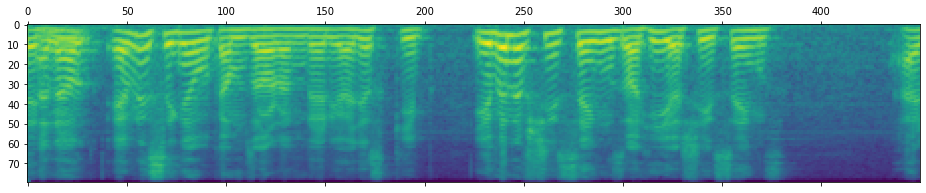

In [ ]:
mel = np.load("/content/drive/MyDrive/Datasets/vox_spectograms/id10002/QanuGhOhb9A_00010.npy")
plt.matshow(mel)

In [ ]:
mel.shape

(80, 450)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Conv1D, MaxPooling1D, Concatenate, BatchNormalization, Dropout
import tensorflow as tf
from keras.optimizers import Adam

In [ ]:
input_spec = Input(name='input_spec', shape=(80,450))
validation_spec = Input(name='validation_spec', shape=(80,450))

In [ ]:
def embedding_model(): 

    input_spec = Input(shape=(80,450,1), name='input_spec')
    
    # First block
    b1_c1 = Conv2D(32, (4,20), activation='relu')(input_spec)
    b1_c2 = Conv2D(32, (4,20), activation='relu')(b1_c1)
    b1_c3 = Conv2D(32, (4,20), activation='relu')(b1_c2)
    b1_o = Dropout(0.3)(b1_c3)
    
    b1_mp = MaxPooling2D((2,2), padding='same')(b1_o)
    
    # Second block
    b2_c1 = Conv2D(64, (4,20), activation='relu')(b1_mp)
    b2_c2 = Conv2D(64, (4,20), activation='relu')(b2_c1)
    b2_c3 = Conv2D(64, (4,20), activation='relu')(b2_c2)
    b2_o = Dropout(0.3)(b2_c3)

    b2_mp = MaxPooling2D((2,2), padding='same')(b2_o)

    # Third block
    b3_c1 = Conv2D(32, (4,20), activation='relu')(b2_mp)
    b3_c2 = Conv2D(32, (4,20), activation='relu')(b3_c1)
    b3_c3 = Conv2D(32, (4,20), activation='relu')(b3_c2)
    b3_o = Dropout(0.3)(b3_c3)

    b3_mp = MaxPooling2D((2,2), padding='same')(b3_o)
    
    # # Fourth block 
    # b4_c1 = Conv2D(256, (4,10), activation='relu')(b3_o)
    # b4_c2 = Conv2D(256, (4,10), activation='relu')(b4_c1)
    # b4_c3 = Conv2D(256, (4,10), activation='relu')(b4_c2)
    # b4_o = Dropout(0.2)(b4_c3)

    # b34_mp = MaxPooling2D((2,2), padding='same')(b4_o)
    
    # # Final embedding block
    # b5_c1 = Conv2D(128, (4,10), activation='relu')(b34_mp)
    # b5_c2 = Conv2D(128, (4,10), activation='relu')(b5_c1)
    # b5_o = Dropout(0.2)(b5_c2)


    f1 = Flatten()(b3_mp)
    fd = Dropout(0.3)(f1)

    d1 = Dense(512, activation='sigmoid')(fd)

    return Model(inputs=[input_spec], outputs=[d1], name='Embedding')

In [ ]:
embedder = embedding_model()
embedder.summary()

Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_spec (InputLayer)     [(None, 80, 450, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 77, 431, 32)       2592      
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 412, 32)       81952     
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 393, 32)       81952     
                                                                 
 dropout (Dropout)           (None, 71, 393, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 197, 32)      0         
 )                                                               
                                                         

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 15.8 MB/s eta 0:00:00


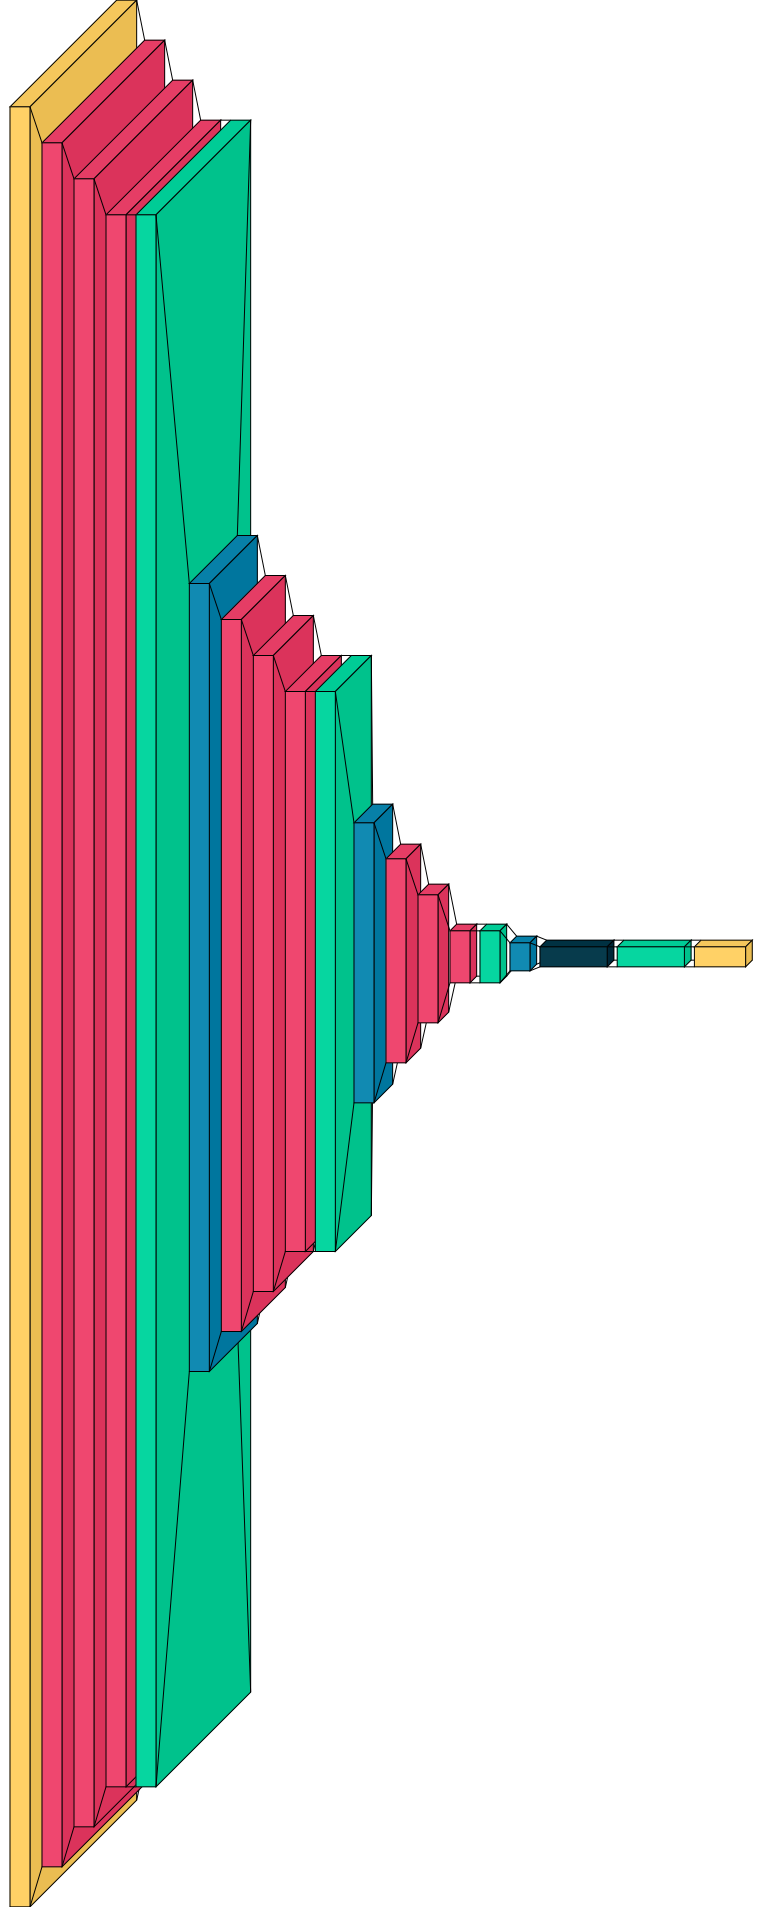

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(embedder)

In [ ]:
def make_siamese_model():
    input_image = Input(name='input_img', shape=(80,450))
    validation_image = Input(name='validation_img', shape=(80,450))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedder(input_image), embedder(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
model = make_siamese_model()
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 80, 450)]    0           []                               
                                                                                                  
 validation_img (InputLayer)    [(None, 80, 450)]    0           []                               
                                                                                                  
 Embedding (Functional)         (None, 512)          1658240     ['input_img[0][0]',              
                                                                  'validation_img[0][0]']         
                                                                                                  
 distance (L1Dist)              (None, 512)          0           ['Embedding[0][0]', 

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/spec_dataset.csv")

In [ ]:
data.head()

,Unnamed: 0,mel_1,mel_2,same
0,0,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
1,1,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
2,2,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
3,3,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1
4,4,/content/drive/MyDrive/Datasets/vox_spectogram...,/content/drive/MyDrive/Datasets/vox_spectogram...,1


In [ ]:
data2 = data.sample(100000)

In [ ]:
len(data2)

100000

In [ ]:
# Define a function to load MFCC data from file paths
def load_mfcc(mfcc_path):
    mfcc = np.load(mfcc_path)
    # mfcc2 = np.load(mfcc2_path)
    return mfcc

In [ ]:
def generator(batch_size):
    cache = {}
    while True:
        batch = data.sample(batch_size)
        X1 = np.zeros((batch_size, 80, 450))
        X2 = np.zeros((batch_size, 80, 450))
        y = batch['same'].values
        for i, (_, row) in enumerate(batch.iterrows()):
            if row['mel_1'] not in cache.keys():
              cache[row['mel_1']] = load_mfcc(row['mel_1'])
            if row['mel_2'] not in cache.keys():
              cache[row['mel_2']] = load_mfcc(row['mel_2'])
            X1[i] = cache[row['mel_1']]
            X2[i] = cache[row['mel_2']]
        yield [X1,X2], y

batch_size = 128
steps_per_epoch = len(data) // batch_size

<ipython-input-34-1fdca740f87b>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.matshow(i[0][1].reshape(80,450))


KeyboardInterrupt: ignored

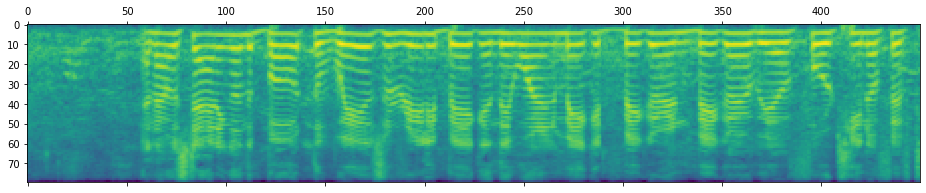

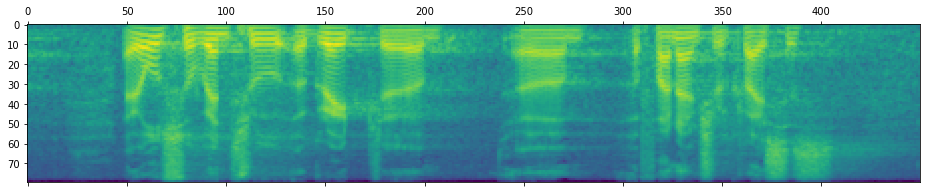

Error in callback <function flush_figures at 0x7f60b2184e50> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
for i in generator(1):
  plt.matshow(i[0][1].reshape(80,450))

In [ ]:
# Compile the model
model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
tensorboard_callback = tf.keras.callbacks.TensorBoard()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.fit(generator(batch_size), epochs= 1, steps_per_epoch=steps_per_epoch, callbacks=[tensorboard_callback])

  2375/184224 [..............................] - ETA: 170:56:27 - loss: 0.2051 - accuracy: 0.9518

KeyboardInterrupt: ignored

In [ ]:
model.save("100K_sample_siam_model_2M.h5")

In [ ]:
model = keras.models.load_model("/content/100K_sample_siam_model_2M.h5",custom_objects={'L1Dist': L1Dist})

In [ ]:
!sudo apt install ffmpeg
!pip install torchaudio ipywebrtc notebook
!jupyter nbextension enable --py widgetsnbextension

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.0 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from ipywebrtc import AudioRecorder, CameraStream
import torchaudio
from IPython.display import Audio

In [ ]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [ ]:
!ffmpeg -i record.webm -ac 1 -f wav Bye5.wav -y -hide_banner -loglevel panic

In [ ]:
audio, mel2 = pattern_generate('/content/Bye5.wav',
                 params['N_FFT'],
                 params['Mel_Dim'],
                 params['Sample_Rate'],
                 params['Frame_Shift'],
                 params['Frame_Length'],
                 params["Mel_F_Min"],
                 params['Mel_F_Max'])

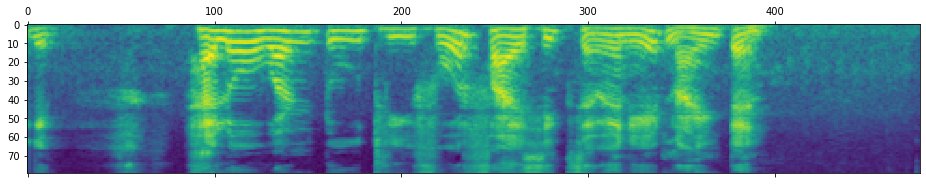

In [ ]:
plt.matshow(mel3)

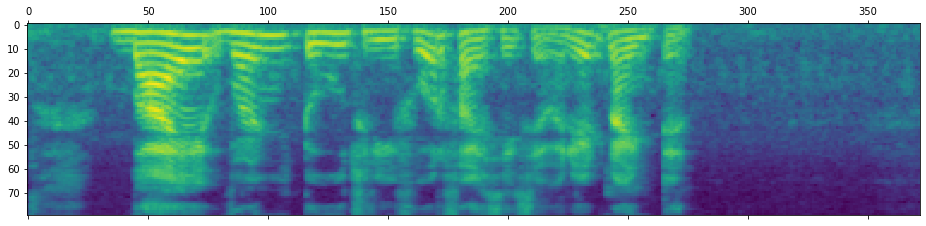

In [ ]:
plt.matshow(mel2)

In [ ]:
audio, mel1 = pattern_generate('/content/ThisIsRishi12345.wav',
                 params['N_FFT'],
                 params['Mel_Dim'],
                 params['Sample_Rate'],
                 params['Frame_Shift'],
                 params['Frame_Length'],
                 params["Mel_F_Min"],
                 params['Mel_F_Max'])

In [ ]:
mel1 = np.load('/content/drive/MyDrive/Datasets/vox_spectograms/id10002/RLKKsYiCMvc_00004.npy')
mel5 = np.load('/content/drive/MyDrive/Datasets/vox_spectograms/id10003/5ablueV_1tw_00002.npy')
mel6 = np.load('/content/drive/MyDrive/Datasets/vox_spectograms/id10003/5ablueV_1tw_00015.npy')
mel4 = np.load("/content/drive/MyDrive/Datasets/vox_spectograms/id10003/A8SBCxYzJgs_00003.npy")

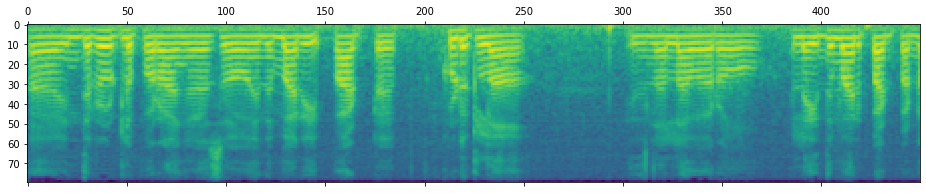

In [ ]:
plt.matshow(mel1.reshape(80,450))

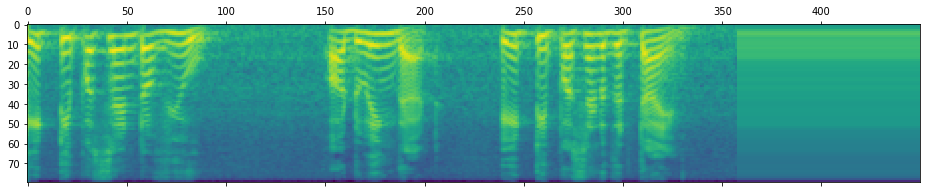

In [ ]:
plt.matshow(mel3.reshape(80,450))

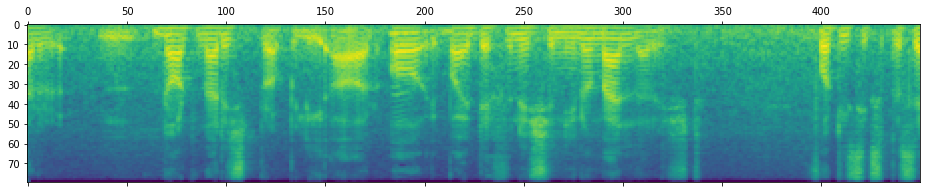

In [ ]:
plt.matshow(mel4.reshape(80,450))

In [ ]:
mel1.shape

(1, 80, 450)

In [ ]:
mel1 = pad_crop(mel1, mode = 'mean')
mel4 = pad_crop(mel4, mode = 'mean')
mel5 = pad_crop(mel5, mode = 'mean')
mel6 = pad_crop(mel6, mode = 'mean')

In [ ]:
mel1 = mel1.reshape(-1, 80, 450)
mel6 = mel6.reshape(-1, 80, 450)
mel5 = mel5.reshape(-1, 80, 450)
mel4 = mel4.reshape(-1, 80, 450)

In [ ]:
model.predict([mel3,mel2])

1/1 [==============================] - 0s 351ms/step


array([[0.11177724]], dtype=float32)

In [ ]:
model.predict([mel6,mel1])

1/1 [==============================] - 0s 234ms/step


array([[0.12540959]], dtype=float32)

In [ ]:
model.predict([mel1,mel4])

1/1 [==============================] - 0s 24ms/step


array([[0.3905362]], dtype=float32)

In [ ]:
model.predict([mel4,mel4])

1/1 [==============================] - 0s 48ms/step


array([[0.4592064]], dtype=float32)

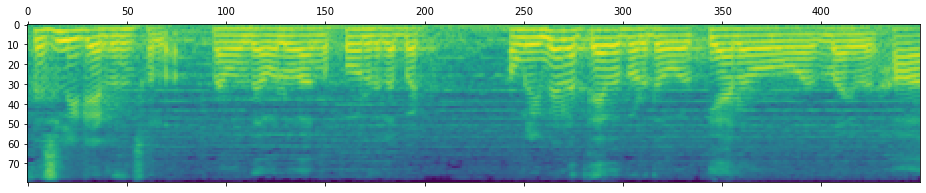

In [ ]:
plt.matshow(mel1.reshape(80,450))

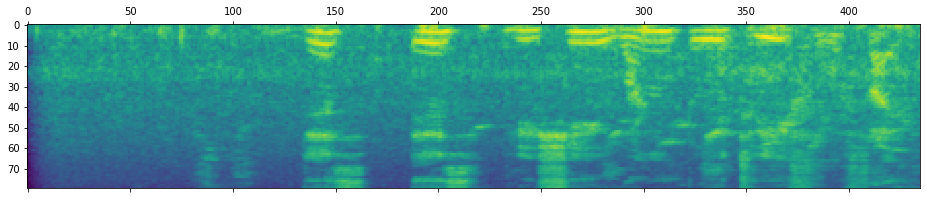

In [ ]:
mel5 = get_mel("/content/ThisIsRishi12345.wav")
plt.matshow(mel5)

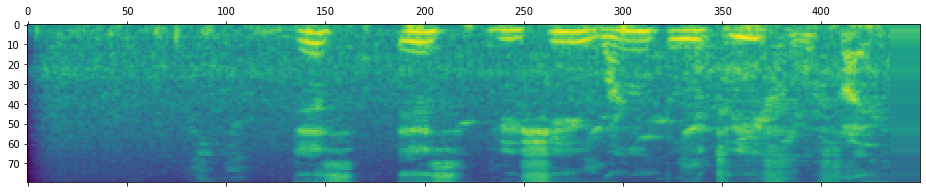

In [ ]:
mel5 = pad_crop(mel5, mode='mean')
plt.matshow(mel5)

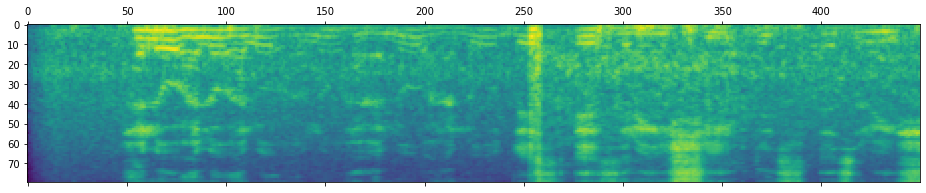

In [ ]:
mel6 = pad_crop(get_mel("/content/HelloHelloThis.wav"), mode='mean')
plt.matshow(mel6)

In [ ]:
mel6.shape

(80, 450)

In [ ]:
mel5 = mel5.reshape(-1,80,450)
mel6 = mel6.reshape(-1,80,450)

In [ ]:
model.predict([mel5,mel6])

1/1 [==============================] - 0s 29ms/step


array([[0.41204512]], dtype=float32)